# Caustics

In [ ]:
# %pip install -U -r requirements.txt

  Using cached numpy-2.3.3-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib
matplotlib.__version__
import matplotlib.gridspec as gs

import numpy as np


In [3]:
import os 
from IPython import get_ipython
ip = get_ipython()
# print(ip.user_ns)
study_name = None
if '__vsc_ipynb_file__' in ip.user_ns:
    # https://github.com/msm1089/ipynbname/issues/17
    study_name = os.path.split(os.path.basename(ip.user_ns['__vsc_ipynb_file__']))[1]
elif '__file__' in ip.user_ns:
    study_name = ip.user_ns['__file__']
else:
    import ipynbname
    study_name = ipynbname.name()
study_name = study_name.replace('.ipynb', '')
study_name

'2024-10-07_caustique-bands'

In [4]:
import os
import numpy as np
# import imageio
import cv2

# the higher PRECISION, the bigger the file
PRECISION = 4  # debugging
PRECISION = 10 # medium quality
PRECISION = 12 # good quality
# PRECISION = 14 # very good quality
# PRECISION = 15 # for production

# https://docs.python.org/3/library/dataclasses.html?highlight=dataclass#module-dataclasses
from dataclasses import dataclass

@dataclass
class init:
    figpath: str = study_name # Folder to store images
    # phi: float = 1.61803 # beauty is gold
    tag: str = 'caustique' # Tag
    ext: str = 'png' # Extension for output
    nx: int = 13*2**PRECISION # number of pixels (vertical)
    ny: int = 1*2**PRECISION # number of pixels (horizontal)
    nframe: int = 1 # number of frames
    bin_dens: int = 2 # relative bin density
    bin_spectrum: int = 1 # bin spacing in spectrum (lower is more CPU)
    seed: int = 2024 # seed for RNG
    H: float = 20.0 # depth of the pool
    variation: float = .20 # variation of diffraction index: http://www.philiplaven.com/p20.html 1.40 at 400 nm and 1.37 at 700nm makes a 2% variation
    scale: float = .95*2**PRECISION # period in pixels
    B_sf: float = 1.00 # bandwidth in sf
    V_Y: float = 0.3 # horizontal speed
    V_X: float = 0.3 # vertical speed
    B_V: float = 1.0 # bandwidth in speed
    zmin: float = 0.10 # relative minimal value of wave height at the top to generate a gradient (set to 1. to have no gradient)
    # theta: float = 2*np.pi*(2-1.61803) # angle with the horizontal
    theta: float = np.pi/2 # angle with the horizontal
    B_theta: float = 60*np.pi/180 # bandwidth in theta
    min_lum: float = .01 # global diffusion level for the rendering giving the pedestal value
    n_bits: int = 16 # bits to save images
    gamma: float = 3. # Gamma exponant to convert luminosity to luminance
    fps: float = 18 # frames per second
    multispectral: bool = True # Compute caustics on the full spectrogram.
    do_cache: bool = True # Cache intermediate output.
    verbose: bool = False # Displays more verbose output.
    do_display: bool = False # Displays images in notebook.
    do_recompute: bool = False # Restart each computation    

In [5]:
opt = init()
print(f'Saving our simulations in={opt.figpath}')

Saving our simulations in=2024-10-07_caustique-bands


In [6]:
# if opt.nframe==1: opt.ext = 'png'

In [7]:
from pprint import pprint
pprint(opt)

init(figpath='2024-10-07_caustique-bands',
     tag='caustique',
     ext='png',
     nx=53248,
     ny=4096,
     nframe=1,
     bin_dens=2,
     bin_spectrum=1,
     seed=2024,
     H=20.0,
     variation=0.2,
     scale=3891.2,
     B_sf=1.0,
     V_Y=0.3,
     V_X=0.3,
     B_V=1.0,
     zmin=0.1,
     theta=1.5707963267948966,
     B_theta=1.0471975511965976,
     min_lum=0.01,
     n_bits=16,
     gamma=3.0,
     fps=18,
     multispectral=True,
     do_cache=True,
     verbose=False,
     do_display=False,
     do_recompute=False)


In [8]:
screen_size_cm = 100 # cm
cm_by_inch = 2.54
screen_size_in = screen_size_cm/cm_by_inch
dpi = (opt.nx // opt.bin_dens) / screen_size_in
print(f'Screen size={screen_size_cm}cm={screen_size_in:.3f}in, dpi={dpi:.0f}dpi')

Screen size=100cm=39.370in, dpi=676dpi


## utilities

Transfoming a sequence of PNG frames into gif or mp4:

In [9]:
def make_gif(gifname, fnames, fps, do_delete=True):
    with imageio.get_writer(gifname, mode='I', fps=fps) as writer:
        for fname in fnames:
            writer.append_data(imageio.imread(fname))

    from pygifsicle import optimize
    optimize(str(gifname))
    if do_delete: 
        for fname in fnames: os.remove(fname)
    return gifname

# https://moviepy.readthedocs.io/en/latest/getting_started/videoclips.html#imagesequenceclip
def make_mp4(mp4name, fnames, fps, do_delete=True):
    import moviepy.editor as mpy
    clip = mpy.ImageSequenceClip(fnames, fps=fps)
    clip.write_videofile(mp4name, fps=fps, codec='libx264', verbose=False, logger=None)
    if do_delete: 
        for fname in fnames: os.remove(fname)
    return mp4name


Utilities to compute the spectrum of the blue sky and convert them later to RGB values (check out https://laurentperrinet.github.io/sciblog/posts/2020-07-04-colors-of-the-sky.html for details)

In [10]:
from lambda2color import Lambda2color, xyz_from_xy

# borrowed from https://github.com/gummiks/gummiks.github.io/blob/master/scripts/astro/planck.py
def planck(wav, T):
    import scipy.constants as const
    c = const.c # c = 3.0e+8
    h = const.h # h = 6.626e-34
    k = const.k # k = 1.38e-23
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a / ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity

def scattering(wav, a=0.005, p=1.3, b=0.45):
    """
    b is  proportionate  to  the  column  density  of  aerosols
    along  the  path  of  sunlight,  from  outside  the  atmosphere
    to  the  point  of  observation
    
    see https://laurentperrinet.github.io/sciblog/posts/2020-07-04-colors-of-the-sky.html for more details

    """
    # converting wav in µm:
    intensity = np.exp(-a/((wav/1e-6)**4)) # Rayleigh extinction by nitrogen
    intensity *= (wav/1e-6)**-4
    intensity *= np.exp(-b/((wav/1e-6)**p)) # Aerosols
    return intensity

## computing the caustics

In [11]:
import matplotlib
subplotpars = matplotlib.gridspec.SubplotParams(left=0., right=1., bottom=0., top=1., wspace=0., hspace=0.,)
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import shutil
import hashlib
import MotionClouds as mc

class Caustique:
    def __init__(self, opt):
        """
        Image coordinates follow 'ij' indexing, that is,
        * their origin at the top left,
        * the X axis is vertical and goes "down",
        * the Y axis is horizontal and goes "right".

        """
        self.mc = mc
        self.ratio = opt.ny/opt.nx # ratio between height and width (>1 for portrait, <1 for landscape)
        X = np.linspace(0, 1, opt.nx, endpoint=False) # vertical
        Y = np.linspace(0, self.ratio, opt.ny, endpoint=False) # horizontal
        self.xv, self.yv = np.meshgrid(X, Y, indexing='ij')
        self.opt = opt
        # https://stackoverflow.com/questions/16878315/what-is-the-right-way-to-treat-python-argparse-namespace-as-a-dictionary
        self.d = vars(opt)
        os.makedirs(self.opt.figpath, exist_ok=True)
        self.cachepath = os.path.join('/tmp', self.opt.figpath)
        if opt.verbose: print(f'{self.cachepath=}')
        os.makedirs(self.cachepath, exist_ok=True)

        # a standard white:
        # illuminant_D65 = xyz_from_xy(0.3127, 0.3291), 
        illuminant_sun = xyz_from_xy(0.325998, 0.335354)
        # color conversion class
        self.cs_srgb = Lambda2color(red=xyz_from_xy(0.64, 0.33),
                               green=xyz_from_xy(0.30, 0.60),
                               blue=xyz_from_xy(0.15, 0.06),
                               white=illuminant_sun)
        self.wavelengths = self.cs_srgb.cmf[:, 0]*1e-9
        self.N_wavelengths = len(self.wavelengths)
        # multiply by the spectrum of the sky
        intensity5800 = planck(self.wavelengths, 5800.)
        scatter = scattering(self.wavelengths)
        self.spectrum_sky = intensity5800 * scatter
        self.spectrum_sky /= self.spectrum_sky.max()

    def wave(self, do_cache=None):
        filename = f'{self.cachepath}/{self.opt.tag}_wave.npy'
        if do_cache is None: do_cache = self.opt.do_cache
        if os.path.isfile(filename) and not(self.opt.do_recompute) and do_cache:
            z = np.load(filename)
        else:
            # A simplistic model of a wave using https://github.com/NeuralEnsemble/MotionClouds
            fx, fy, ft = mc.get_grids(self.opt.nx, self.opt.ny, self.opt.nframe)
            env = mc.envelope_gabor(fx, fy, ft, V_X=self.opt.V_Y, V_Y=self.opt.V_X, B_V=self.opt.B_V,
                                    sf_0=1./self.opt.scale, B_sf=self.opt.B_sf/self.opt.scale,
                                    theta=self.opt.theta, B_theta=self.opt.B_theta)
            z = mc.rectif(mc.random_cloud(env, seed=self.opt.seed))
            if do_cache: np.save(filename, z)
        return z * np.linspace(self.opt.zmin, 1., self.opt.nx)[:, None, None]

    def transform(self, z_, modulation=1., edge_order=2):
        xv, yv = self.xv.copy(), self.yv.copy()

        # dzdx = z_ - np.roll(z_, 1, axis=0)
        # dzdy = z_ - np.roll(z_, 1, axis=1)

        # https://numpy.org/doc/stable/reference/generated/numpy.gradient.html
        # dzdx = np.gradient(z_, axis=0, edge_order=edge_order)
        # dzdy = np.gradient(z_, axis=1, edge_order=edge_order)
        dzdx, dzdy = np.gradient(z_, edge_order=edge_order)

        xv = xv + modulation * self.opt.H * dzdx
        yv = yv + modulation * self.opt.H * dzdy

        xv = np.mod(xv, 1)
        yv = np.mod(yv, self.ratio)

        return xv, yv

    def get_filename(self):
        # output filename        
        md5 = hashlib.sha224((self.opt.figpath + self.opt.tag).encode()).hexdigest()[:8] # an unique identifier for future tagging
        output_filename = f'{self.opt.figpath}/{self.opt.tag}_{md5}.{self.opt.ext}'
        return output_filename

    def plot(self, z, image=None, do_color=True, dpi=dpi):
        """
        
        dpi: output resolution - sets the figure size as we ensure there is a one to one correspondance between pixels in the data and the output image
        """

        output_filename = self.get_filename()
        if os.path.isfile(output_filename) and not(self.opt.do_recompute):
            return output_filename
        else:
            # 1/ do the raytracing of image through z:
            binsx, binsy = self.opt.nx//self.opt.bin_dens, self.opt.ny//self.opt.bin_dens

            # a fixed image in degree of contrast (from 0=black to 1=white)
            if image is None: image = np.ones((self.opt.nx, self.opt.ny))

            #hist = self.do_raytracing(z)
            binsx, binsy = self.opt.nx//self.opt.bin_dens, self.opt.ny//self.opt.bin_dens


            if self.opt.multispectral:

                #image_rgb = self.cs_srgb.spec_to_rgb(hist)
                image_rgb = np.zeros((self.opt.nx//self.opt.bin_dens,  self.opt.ny//self.opt.bin_dens, 3, self.opt.nframe))
                for i_frame in trange(self.opt.nframe):
                    for i_wavelength in trange(self.opt.bin_spectrum//2, self.N_wavelengths, self.opt.bin_spectrum):
                        modulation = 1. + self.opt.variation/2 - self.opt.variation*i_wavelength/self.N_wavelengths
                        xv, yv = self.transform(z[:, :, i_frame], modulation=modulation)
                        hist_, _, _ = np.histogram2d(xv.ravel(), yv.ravel(),
                                                     bins=[binsx, binsy],
                                                     weights=image.ravel(),
                                                     range=[[0, 1], [0, self.ratio]],
                                                     density=True)

                        # we convert the spectrum into a color
                        spec = np.zeros((self.N_wavelengths))
                        spec[i_wavelength] = 1
                        rgb = self.cs_srgb.spec_to_rgb(spec)
                        rgb *= self.spectrum_sky[i_wavelength]
                        # we add the color to the image
                        image_rgb[:, :, :, i_frame] += hist_[:, :, None] * rgb[None, None, :]

                image_rgb -= image_rgb.min()
                image_rgb /= image_rgb.max()
            else:
                hist = np.zeros((binsx, binsy, self.opt.nframe))
                for i_frame in trange(self.opt.nframe):
                    xv, yv = self.transform(z[:, :, i_frame])
                    hist_, _, _ = np.histogram2d(xv.ravel(), yv.ravel(),
                                                        bins=[binsx, binsy],
                                                        range=[[0, 1], [0, self.ratio]],
                                                        density=True)
                #hist /= hist.max()

            # 2/ transform light into image:
            fnames = []
            for i_frame in trange(self.opt.nframe):
                fig, ax = plt.subplots(figsize=(self.opt.ny/self.opt.bin_dens/dpi, self.opt.nx/self.opt.bin_dens/dpi), subplotpars=subplotpars)
                if self.opt.multispectral:
                    image_array = image_rgb[:, :, :, i_frame] ** (1/self.opt.gamma)
                    ax.imshow(image_array, vmin=0, vmax=1)
                else:
                    if do_color:
                        bluesky = np.array([0.268375, 0.283377]) # xyz
                        sun = np.array([0.325998, 0.335354]) # xyz
                        # ax.pcolormesh(edge_y, edge_x, hist[:, :, i_frame], vmin=0, vmax=1, cmap=plt.cm.Blues_r)
                        # https://en.wikipedia.org/wiki/CIE_1931_color_space#Mixing_colors_specified_with_the_CIE_xy_chromaticity_diagram
                        L1 = 1 - hist[:, :, i_frame]
                        L2 = hist[:, :, i_frame]
                        image_denom = L1 / bluesky[1] + L2 / sun[1]
                        image_x = (L1 * bluesky[0] / bluesky[1] + L2 * sun[0] / sun[1]) / image_denom
                        image_y = (L1 + L2) / image_denom 
                        image_xyz = np.dstack((image_x, image_y, 1 - image_x - image_y))
                        image_rgb = self.cs_srgb.xyz_to_rgb(image_xyz)
                        image_L = (self.opt.min_lum + (1-self.opt.min_lum)* L2) ** (1/self.opt.gamma)
                        image_array = image_L[:, :, None]*image_rgb
                        ax.imshow(image_array, vmin=0, vmax=1)
                    else:
                        ax.imshow(1-image_L, vmin=0, vmax=1)

                fname = f'{self.cachepath}/{self.opt.tag}_frame_{i_frame:04d}.png'
                
                # fig.savefig(fname, dpi=dpi)
                np_dtype = np.uint8 if self.opt.n_bits==8 else np.uint16
                # imageio.imsave(fname, image_array.astype(np_dtype), dpi=dpi, extension=opt.ext)
                cv2.imwrite(fname, (image_array*(2**self.opt.n_bits-1)).astype(np_dtype))
                fnames.append(fname)
                plt.close(fig)

            if self.opt.nframe==1:
                shutil.move(fname, output_filename)
                return output_filename
            else:
                if self.opt.ext == 'gif':
                    return make_gif(output_filename, fnames, fps=self.opt.fps)
                else:
                    return make_mp4(output_filename, fnames, fps=self.opt.fps)

    def show(self, output_filename, width=1024):
        from IPython.display import HTML, Image, display
        if self.opt.nframe==1:
            # display(Image(url=output_filename.replace(self.opt.ext, 'png'), width=width))
            display(Image(url=output_filename, width=width))
        else:
            if self.opt.ext == 'gif':
                return display(Image(url=output_filename, width=width))
            else:
                #import moviepy.editor as mpy
                #return mpy.ipython_display(output_filename, width=width)
                # https://github.com/NeuralEnsemble/MotionClouds/blob/master/MotionClouds/MotionClouds.py#L858
                opts = ' loop="1" autoplay="1" controls '
                html = HTML(f'<video {opts} src="{output_filename}" type="video/{self.opt.ext}" width={width}\>')
                html.reload()
                return display(html)

<>:198: SyntaxWarning: invalid escape sequence '\>'
<>:198: SyntaxWarning: invalid escape sequence '\>'
/tmp/ipykernel_24067/4028701564.py:198: SyntaxWarning: invalid escape sequence '\>'
  html = HTML(f'<video {opts} src="{output_filename}" type="video/{self.opt.ext}" width={width}\>')


# a simple caustics

## generating the caustics

In [12]:
c = Caustique(opt)
z = c.wave()
z.shape

(53248, 4096, 1)

In [13]:
type = 'grating'

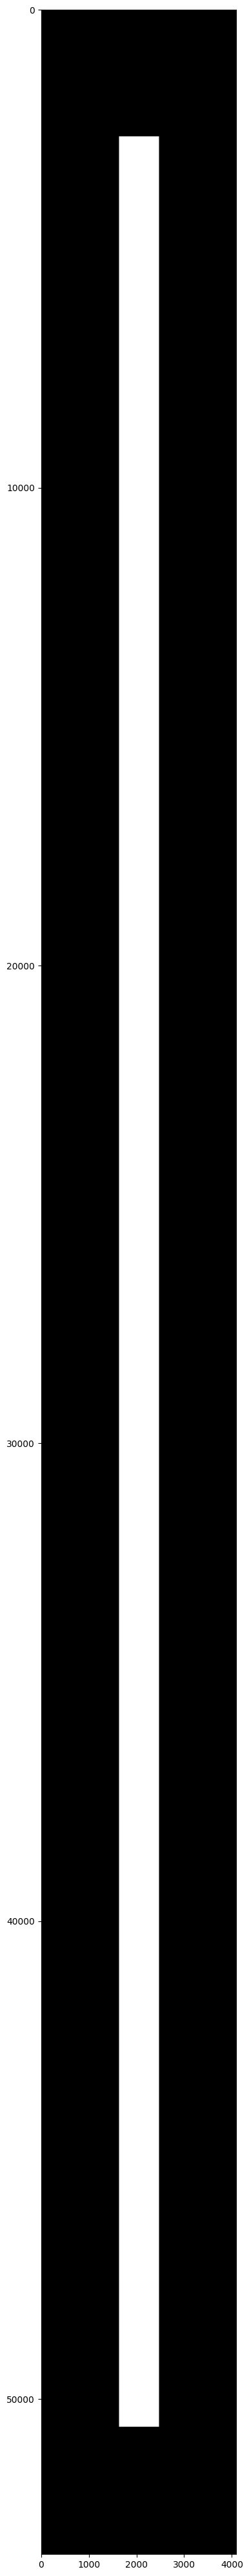

In [14]:
def generate_image(nx, ny, periods=.5, threshold=0.80, radius=.9):
    Y, X = np.meshgrid(np.linspace(-1, 1, ny, endpoint=True), np.linspace(-1, 1, nx, endpoint=True))
    image = (np.cos(2*np.pi*Y*periods) > threshold)*1.
    # image += (np.cos(2*np.pi*Y*periods) > threshold)*1.
    # image = (image>=1) * 1.
    image *= (X**2 < radius**2) * (Y**2 < radius**2) * 1.
    return image
image = generate_image(nx=c.opt.nx, ny=c.opt.ny)

fig, ax = plt.subplots(figsize=(opt.ny/opt.bin_dens/dpi, opt.nx/opt.bin_dens/dpi), subplotpars=subplotpars)

ax.imshow(image, cmap='gray');

In [15]:
c = Caustique(opt)
output_filename = c.plot(z, image)

100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


In [16]:
c.show(output_filename)

# exploring parameters

In [17]:
N_scan = 7
base = 4

## water depth

In [18]:
for H_ in c.opt.H*np.logspace(-1, 1, N_scan, base=base):
    opt = init()
    c = Caustique(opt)
    c.opt.H = H_
    c.opt.tag = f'{c.opt.tag}_H_{H_:.3f}'
    
    output_filename = c.plot(z, image)
    print(f'H = {H_:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


H = 5.000 -> output_filename='2024-10-07_caustique-bands/caustique_H_5.000_2d6e250a.png' 


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


H = 7.937 -> output_filename='2024-10-07_caustique-bands/caustique_H_7.937_07e86961.png' 


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


H = 12.599 -> output_filename='2024-10-07_caustique-bands/caustique_H_12.599_bcaecb61.png' 


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


H = 20.000 -> output_filename='2024-10-07_caustique-bands/caustique_H_20.000_653704ed.png' 


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


H = 31.748 -> output_filename='2024-10-07_caustique-bands/caustique_H_31.748_9eead4c4.png' 


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


H = 50.397 -> output_filename='2024-10-07_caustique-bands/caustique_H_50.397_8b2d43b8.png' 


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

H = 80.000 -> output_filename='2024-10-07_caustique-bands/caustique_H_80.000_e4b575d3.png' 


## refraction index variation

In [19]:
for variation_ in np.logspace(-2, 0, N_scan, base=10, endpoint=False):
    opt = init()
    c = Caustique(opt)
    c.opt.variation = variation_
    c.opt.tag = f'{opt.tag}_variation_{variation_:.3f}'

    output_filename = c.plot(z, image)
    print(f'variation = {variation_:.3f}  -> {output_filename=}')
    if c.opt.do_display: c.show(output_filename)

100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


variation = 0.010  -> output_filename='2024-10-07_caustique-bands/caustique_variation_0.010_ca5c510d.png'


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


variation = 0.019  -> output_filename='2024-10-07_caustique-bands/caustique_variation_0.019_0272594e.png'


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


variation = 0.037  -> output_filename='2024-10-07_caustique-bands/caustique_variation_0.037_4c38ebad.png'


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


variation = 0.072  -> output_filename='2024-10-07_caustique-bands/caustique_variation_0.072_2aff644b.png'


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


variation = 0.139  -> output_filename='2024-10-07_caustique-bands/caustique_variation_0.139_ba4a1ff8.png'


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


variation = 0.268  -> output_filename='2024-10-07_caustique-bands/caustique_variation_0.268_3f08fa81.png'


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]

variation = 0.518  -> output_filename='2024-10-07_caustique-bands/caustique_variation_0.518_910d3fe1.png'


## post-processing

In [20]:
for variable in ['gamma', 'min_lum']: 
    print(f'======{variable}======')
    for modul in np.logspace(-1, 1, N_scan, base=base):
        opt = init()
        c = Caustique(opt)
        c.d[variable] *= modul
        c.opt.tag = f'{c.opt.tag}_{variable}_modul_{modul:.3f}'
        
        output_filename = c.plot(z, image)
        print(f'{variable}={variable}(default)*{modul:.3f}={c.d[variable]:.3E} -> {output_filename=}')
        if c.opt.do_display: c.show(output_filename)

======gamma======


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


gamma=gamma(default)*0.250=7.500E-01 -> output_filename='2024-10-07_caustique-bands/caustique_gamma_modul_0.250_cda9494d.png'


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


gamma=gamma(default)*0.397=1.191E+00 -> output_filename='2024-10-07_caustique-bands/caustique_gamma_modul_0.397_db6ec9ec.png'


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


gamma=gamma(default)*0.630=1.890E+00 -> output_filename='2024-10-07_caustique-bands/caustique_gamma_modul_0.630_69bce8bf.png'


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


gamma=gamma(default)*1.000=3.000E+00 -> output_filename='2024-10-07_caustique-bands/caustique_gamma_modul_1.000_1809f229.png'


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


gamma=gamma(default)*1.587=4.762E+00 -> output_filename='2024-10-07_caustique-bands/caustique_gamma_modul_1.587_f9ca17ff.png'


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


gamma=gamma(default)*2.520=7.560E+00 -> output_filename='2024-10-07_caustique-bands/caustique_gamma_modul_2.520_1b8157d2.png'


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


gamma=gamma(default)*4.000=1.200E+01 -> output_filename='2024-10-07_caustique-bands/caustique_gamma_modul_4.000_ce6a3712.png'
======min_lum======


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


min_lum=min_lum(default)*0.250=2.500E-03 -> output_filename='2024-10-07_caustique-bands/caustique_min_lum_modul_0.250_6e85f09a.png'


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


min_lum=min_lum(default)*0.397=3.969E-03 -> output_filename='2024-10-07_caustique-bands/caustique_min_lum_modul_0.397_b0dc09a3.png'


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


min_lum=min_lum(default)*0.630=6.300E-03 -> output_filename='2024-10-07_caustique-bands/caustique_min_lum_modul_0.630_ce1dda16.png'


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


min_lum=min_lum(default)*1.000=1.000E-02 -> output_filename='2024-10-07_caustique-bands/caustique_min_lum_modul_1.000_403a1c35.png'


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


min_lum=min_lum(default)*1.587=1.587E-02 -> output_filename='2024-10-07_caustique-bands/caustique_min_lum_modul_1.587_510e80bc.png'


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


min_lum=min_lum(default)*2.520=2.520E-02 -> output_filename='2024-10-07_caustique-bands/caustique_min_lum_modul_2.520_39ad885f.png'


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]

min_lum=min_lum(default)*4.000=4.000E-02 -> output_filename='2024-10-07_caustique-bands/caustique_min_lum_modul_4.000_48dea967.png'


## other instances of the wave

In [21]:
for seed_increment in range(10):
    opt = init()
    c = Caustique(opt)
    c.d['seed'] = c.d['seed'] + seed_increment
    c.opt.tag = f'{c.opt.tag}_seed_{c.d['seed']}'
    
    z = c.wave()
    output_filename = c.plot(z, image)
    print(f'seed={c.d['seed']} -> {output_filename=}')
    if c.opt.do_display: c.show(output_filename)

100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


seed=2024 -> output_filename='2024-10-07_caustique-bands/caustique_seed_2024_8a635f7f.png'


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


seed=2025 -> output_filename='2024-10-07_caustique-bands/caustique_seed_2025_0c2bdff7.png'


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


seed=2026 -> output_filename='2024-10-07_caustique-bands/caustique_seed_2026_3ba653f2.png'


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


seed=2027 -> output_filename='2024-10-07_caustique-bands/caustique_seed_2027_e06e5d26.png'


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


seed=2028 -> output_filename='2024-10-07_caustique-bands/caustique_seed_2028_16ce89a1.png'


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


seed=2029 -> output_filename='2024-10-07_caustique-bands/caustique_seed_2029_f60965dc.png'


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


seed=2030 -> output_filename='2024-10-07_caustique-bands/caustique_seed_2030_62cc00ce.png'


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


seed=2031 -> output_filename='2024-10-07_caustique-bands/caustique_seed_2031_390a49d4.png'


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


seed=2032 -> output_filename='2024-10-07_caustique-bands/caustique_seed_2032_c0e1b115.png'


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]

seed=2033 -> output_filename='2024-10-07_caustique-bands/caustique_seed_2033_4695784e.png'


## other variables on the wave

In [22]:
for variable in ['scale', 'B_sf', 'theta',  'B_theta', 'zmin']: #  'V_Y', 'V_X', 'B_V', 
    print(f'======{variable}======')
    for modul in np.logspace(-1, 1, N_scan, base=base):
        opt = init()
        c = Caustique(opt)
        c.d[variable] *= modul
        c.opt.tag = f'{c.opt.tag}_{variable}_modul_{modul:.3f}'
        
        output_filename = c.get_filename()
        if os.path.isfile(output_filename) and not(c.opt.do_recompute):            
            z = c.wave(do_cache=False)
            output_filename_ = c.plot(z, image)
            assert(output_filename == output_filename_)
        print(f'{variable}={variable}(default)*{modul:.3f}={c.d[variable]:.3E} -> {output_filename=}')
        if c.opt.do_display: c.show(output_filename)

======scale======
scale=scale(default)*0.250=9.728E+02 -> output_filename='2024-10-07_caustique-bands/caustique_scale_modul_0.250_348bc94c.png'
scale=scale(default)*0.397=1.544E+03 -> output_filename='2024-10-07_caustique-bands/caustique_scale_modul_0.397_734677a9.png'
scale=scale(default)*0.630=2.451E+03 -> output_filename='2024-10-07_caustique-bands/caustique_scale_modul_0.630_cdd8e29e.png'
scale=scale(default)*1.000=3.891E+03 -> output_filename='2024-10-07_caustique-bands/caustique_scale_modul_1.000_ea9920e5.png'
scale=scale(default)*1.587=6.177E+03 -> output_filename='2024-10-07_caustique-bands/caustique_scale_modul_1.587_7c2e8f1f.png'
scale=scale(default)*2.520=9.805E+03 -> output_filename='2024-10-07_caustique-bands/caustique_scale_modul_2.520_5f51613d.png'
scale=scale(default)*4.000=1.556E+04 -> output_filename='2024-10-07_caustique-bands/caustique_scale_modul_4.000_a8c09d48.png'
======B_sf======
B_sf=B_sf(default)*0.250=2.500E-01 -> output_filename='2024-10-07_caustique-bands/c

## shining a grating image to the wave

In [23]:
c = Caustique(init())
c.opt.tag = f'{c.opt.tag}_{type}-image'
output_filename = c.plot(z, image)
c.show(output_filename)

100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


In [24]:
for H_ in c.opt.H*np.logspace(-1, 1, N_scan, base=base):
    opt = init()
    c = Caustique(opt)
    c.opt.H = H_
    c.opt.tag = f'{c.opt.tag}_{type}-image_H_{H_:.3f}'
    
    output_filename = c.plot(z, image)
    print(f'H = {H_:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


H = 5.000 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_H_5.000_7fc6bfa2.png' 


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


H = 7.937 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_H_7.937_aef823b0.png' 


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


H = 12.599 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_H_12.599_c3479b74.png' 


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


H = 20.000 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_H_20.000_0c10eef2.png' 


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


H = 31.748 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_H_31.748_ec73fb83.png' 


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


H = 50.397 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_H_50.397_2fddb771.png' 


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]

H = 80.000 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_H_80.000_118596f1.png' 


In [25]:
for threshold in np.linspace(0, 1, N_scan+2, endpoint=True)[1:-1]:
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_{type}-image_{threshold=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, threshold=threshold)
    output_filename = c.plot(z, image)
    print(f'{threshold:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


0.125 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_threshold=0.125_88e078ca.png' 


100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


0.250 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_threshold=0.250_fd3598b8.png' 


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


0.375 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_threshold=0.375_b23439dc.png' 


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


0.500 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_threshold=0.500_708072a6.png' 


100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


0.625 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_threshold=0.625_4deed9b3.png' 


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


0.750 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_threshold=0.750_52e315cb.png' 


100%|██████████| 1/1 [00:02<00:00,  2.00s/it]

0.875 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_threshold=0.875_15c26694.png' 


In [26]:
for radius in np.linspace(0, 1, N_scan+1)[1:]:
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_{type}-image_{radius=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, radius=radius)
    output_filename = c.plot(z, image)
    print(f'{radius=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


radius=0.143 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_radius=0.143_5ac8826c.png' 


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


radius=0.286 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_radius=0.286_2cf35ab3.png' 


100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


radius=0.429 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_radius=0.429_1bcb1677.png' 


100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


radius=0.571 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_radius=0.571_2c2ae87b.png' 


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


radius=0.714 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_radius=0.714_dc6b28b7.png' 


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


radius=0.857 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_radius=0.857_6fb4079b.png' 


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]

radius=1.000 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_radius=1.000_57c235d8.png' 


In [27]:
for periods in np.logspace(0, 1, N_scan, base=10):
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_{type}-image_{periods=:.2e}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, periods=periods)
    output_filename = c.plot(z, image)
    print(f'{periods=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


periods=1.000 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_periods=1.00e+00_739fbe5c.png' 


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


periods=1.468 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_periods=1.47e+00_69b7f0df.png' 


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


periods=2.154 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_periods=2.15e+00_27992bd3.png' 


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


periods=3.162 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_periods=3.16e+00_58420fd5.png' 


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


periods=4.642 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_periods=4.64e+00_e8aa972d.png' 


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


periods=6.813 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_periods=6.81e+00_7b777f26.png' 


100%|██████████| 1/1 [00:02<00:00,  2.45s/it]

periods=10.000 -> output_filename='2024-10-07_caustique-bands/caustique_grating-image_periods=1.00e+01_617a9825.png' 


In [28]:
for variable in ['scale', 'B_sf', 'theta',  'B_theta', 'gamma', 'min_lum', 'zmin']: #  'V_Y', 'V_X', 'B_V', 
    print(f'======{variable}======')
    for modul in np.logspace(-1, 1, N_scan, base=base):
        opt = init()
        c = Caustique(opt)
        c.d[variable] *= modul
        c.opt.tag = f'{c.opt.tag}_{variable}_modul_{modul:.3f}'
        z = c.wave(do_cache=False)
        image = generate_image(nx=c.opt.nx, ny=c.opt.ny)
        output_filename = c.plot(z, image)
        print(f'{variable}={variable}(default)*{modul:.3f}={c.d[variable]:.3E} -> {output_filename=}')
        if c.opt.do_display: c.show(output_filename)

======scale======
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


100%|██████████| 1/1 [00:03<00:00,  3.24s/it]


scale=scale(default)*0.250=9.728E+02 -> output_filename='2024-10-07_caustique-bands/caustique_scale_modul_0.250_348bc94c.png'


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


scale=scale(default)*0.397=1.544E+03 -> output_filename='2024-10-07_caustique-bands/caustique_scale_modul_0.397_734677a9.png'


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


scale=scale(default)*0.630=2.451E+03 -> output_filename='2024-10-07_caustique-bands/caustique_scale_modul_0.630_cdd8e29e.png'


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


scale=scale(default)*1.000=3.891E+03 -> output_filename='2024-10-07_caustique-bands/caustique_scale_modul_1.000_ea9920e5.png'


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


scale=scale(default)*1.587=6.177E+03 -> output_filename='2024-10-07_caustique-bands/caustique_scale_modul_1.587_7c2e8f1f.png'


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


scale=scale(default)*2.520=9.805E+03 -> output_filename='2024-10-07_caustique-bands/caustique_scale_modul_2.520_5f51613d.png'


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


scale=scale(default)*4.000=1.556E+04 -> output_filename='2024-10-07_caustique-bands/caustique_scale_modul_4.000_a8c09d48.png'
======B_sf======


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


B_sf=B_sf(default)*0.250=2.500E-01 -> output_filename='2024-10-07_caustique-bands/caustique_B_sf_modul_0.250_e57ead10.png'


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


B_sf=B_sf(default)*0.397=3.969E-01 -> output_filename='2024-10-07_caustique-bands/caustique_B_sf_modul_0.397_4a604984.png'


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


B_sf=B_sf(default)*0.630=6.300E-01 -> output_filename='2024-10-07_caustique-bands/caustique_B_sf_modul_0.630_f5461c92.png'


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


B_sf=B_sf(default)*1.000=1.000E+00 -> output_filename='2024-10-07_caustique-bands/caustique_B_sf_modul_1.000_a661a52e.png'


100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


B_sf=B_sf(default)*1.587=1.587E+00 -> output_filename='2024-10-07_caustique-bands/caustique_B_sf_modul_1.587_a218b0d6.png'


100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


B_sf=B_sf(default)*2.520=2.520E+00 -> output_filename='2024-10-07_caustique-bands/caustique_B_sf_modul_2.520_0c8de871.png'


100%|██████████| 1/1 [00:03<00:00,  3.13s/it]


B_sf=B_sf(default)*4.000=4.000E+00 -> output_filename='2024-10-07_caustique-bands/caustique_B_sf_modul_4.000_86ea3faf.png'
======theta======


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


theta=theta(default)*0.250=3.927E-01 -> output_filename='2024-10-07_caustique-bands/caustique_theta_modul_0.250_81afb82b.png'


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


theta=theta(default)*0.397=6.234E-01 -> output_filename='2024-10-07_caustique-bands/caustique_theta_modul_0.397_30f94d25.png'


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


theta=theta(default)*0.630=9.895E-01 -> output_filename='2024-10-07_caustique-bands/caustique_theta_modul_0.630_66df7a62.png'


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


theta=theta(default)*1.000=1.571E+00 -> output_filename='2024-10-07_caustique-bands/caustique_theta_modul_1.000_7a6ba4a2.png'


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


theta=theta(default)*1.587=2.493E+00 -> output_filename='2024-10-07_caustique-bands/caustique_theta_modul_1.587_54d35875.png'


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


theta=theta(default)*2.520=3.958E+00 -> output_filename='2024-10-07_caustique-bands/caustique_theta_modul_2.520_1399553f.png'


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


theta=theta(default)*4.000=6.283E+00 -> output_filename='2024-10-07_caustique-bands/caustique_theta_modul_4.000_62376974.png'
======B_theta======


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


B_theta=B_theta(default)*0.250=2.618E-01 -> output_filename='2024-10-07_caustique-bands/caustique_B_theta_modul_0.250_06e8b02e.png'


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


B_theta=B_theta(default)*0.397=4.156E-01 -> output_filename='2024-10-07_caustique-bands/caustique_B_theta_modul_0.397_00bdd4a6.png'


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


B_theta=B_theta(default)*0.630=6.597E-01 -> output_filename='2024-10-07_caustique-bands/caustique_B_theta_modul_0.630_d9cf1128.png'


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


B_theta=B_theta(default)*1.000=1.047E+00 -> output_filename='2024-10-07_caustique-bands/caustique_B_theta_modul_1.000_c6a29862.png'


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


B_theta=B_theta(default)*1.587=1.662E+00 -> output_filename='2024-10-07_caustique-bands/caustique_B_theta_modul_1.587_a6ebfa6b.png'


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


B_theta=B_theta(default)*2.520=2.639E+00 -> output_filename='2024-10-07_caustique-bands/caustique_B_theta_modul_2.520_b63b53bd.png'


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


B_theta=B_theta(default)*4.000=4.189E+00 -> output_filename='2024-10-07_caustique-bands/caustique_B_theta_modul_4.000_c3098889.png'
======gamma======
gamma=gamma(default)*0.250=7.500E-01 -> output_filename='2024-10-07_caustique-bands/caustique_gamma_modul_0.250_cda9494d.png'
gamma=gamma(default)*0.397=1.191E+00 -> output_filename='2024-10-07_caustique-bands/caustique_gamma_modul_0.397_db6ec9ec.png'
gamma=gamma(default)*0.630=1.890E+00 -> output_filename='2024-10-07_caustique-bands/caustique_gamma_modul_0.630_69bce8bf.png'
gamma=gamma(default)*1.000=3.000E+00 -> output_filename='2024-10-07_caustique-bands/caustique_gamma_modul_1.000_1809f229.png'
gamma=gamma(default)*1.587=4.762E+00 -> output_filename='2024-10-07_caustique-bands/caustique_gamma_modul_1.587_f9ca17ff.png'
gamma=gamma(default)*2.520=7.560E+00 -> output_filename='2024-10-07_caustique-bands/caustique_gamma_modul_2.520_1b8157d2.png'
gamma=gamma(default)*4.000=1.200E+01 -> output_filename='2024-10-07_caustique-bands/caustique_

100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


zmin=zmin(default)*0.250=2.500E-02 -> output_filename='2024-10-07_caustique-bands/caustique_zmin_modul_0.250_db37e98a.png'


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


zmin=zmin(default)*0.397=3.969E-02 -> output_filename='2024-10-07_caustique-bands/caustique_zmin_modul_0.397_23d4cd4b.png'


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


zmin=zmin(default)*0.630=6.300E-02 -> output_filename='2024-10-07_caustique-bands/caustique_zmin_modul_0.630_01f62ac4.png'


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


zmin=zmin(default)*1.000=1.000E-01 -> output_filename='2024-10-07_caustique-bands/caustique_zmin_modul_1.000_7e66bff3.png'


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


zmin=zmin(default)*1.587=1.587E-01 -> output_filename='2024-10-07_caustique-bands/caustique_zmin_modul_1.587_5b1e5f2d.png'


100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


zmin=zmin(default)*2.520=2.520E-01 -> output_filename='2024-10-07_caustique-bands/caustique_zmin_modul_2.520_f725a573.png'


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

zmin=zmin(default)*4.000=4.000E-01 -> output_filename='2024-10-07_caustique-bands/caustique_zmin_modul_4.000_ddb1a9eb.png'
